In [1]:
import os,torch
import torch.nn.functional as tf
from torch import nn
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from vis_utils import show_img_batch
%matplotlib inline

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
mnist = MNIST(root="../Data/", download=False, 
              transform=transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.5,), (0.5,))]))
mnist_dl = DataLoader(mnist, batch_size=128, shuffle=True)

In [4]:
class GenConvTransposeBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, final=False):
        super().__init__()
        if not final:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, 
                                   out_channels=out_channels, 
                                   kernel_size=kernel_size,
                                   stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, 
                                   out_channels=out_channels, 
                                   kernel_size= kernel_size, 
                                   stride=stride),
                nn.Tanh()
            )

    def forward(self, x):
        return self.block(x)

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim, im_chan=1, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            GenConvTransposeBlock(z_dim, hidden_dim * 4),
            GenConvTransposeBlock(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            GenConvTransposeBlock(hidden_dim * 2, hidden_dim * 1),
            GenConvTransposeBlock(hidden_dim * 1, im_chan,  kernel_size=4, final=True)
        )

    def unsqueeze_noise(self, x):
        return x.view(len(x), self.z_dim, 1, 1)
    
    def forward(self, x):
        x = self.unsqueeze_noise(x)
        return self.gen(x)

In [6]:
def get_noise(n_samples, z_dim, device):
    return torch.randn((n_samples, z_dim), device=device)

In [7]:
class DiscConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, final=False):
        super().__init__()
        if not final:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size=kernel_size,
                          stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size= kernel_size, 
                          stride=stride),
            )

    def forward(self, x):
        return self.block(x)

In [8]:
class Discriminator(nn.Module):

    def __init__(self, im_chan, n_classes, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Sequential(
            DiscConvBlock(im_chan, hidden_dim * 1),
            DiscConvBlock(hidden_dim * 1, hidden_dim * 2)
            )
        self.adv_head = DiscConvBlock(hidden_dim * 2, 1, final=True)
        self.aux_head = DiscConvBlock(hidden_dim * 2, n_classes, final=True)
        
    def forward(self, x):
        x = self.hidden(x)
        adv = self.adv_head(x).view(len(x), -1)
        aux = self.aux_head(x).view(len(x), -1)
        return tf.sigmoid(adv), tf.softmax(aux)

In [9]:
n_samples = 128
z_dim = 10
hidden_dim = 64
noise_input = get_noise(n_samples, z_dim, device)
real, labels = next(iter(mnist_dl))
gen = Generator(z_dim=z_dim, im_chan=1, hidden_dim=64).to(device)
fake = gen(noise_input)
disc = Discriminator(1, 10, 64).to(device)
adv, aux = disc(fake)

/var/folders/v0/7qsx_21d0qj1gh5gtygr9yzw0000gn/T/ipykernel_71899/1295700046.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return tf.sigmoid(adv), tf.softmax(aux)


In [10]:
mnist_shape = (1, 28, 28)
n_classes = 10
im_chan=1

adv_loss = nn.BCELoss()
aux_loss = nn.CrossEntropyLoss()
z_dim = 64
display_step = 5000
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002


beta_1 = 0.5 
beta_2 = 0.999

In [13]:
# Initialize the generator and discriminator
gen = Generator(z_dim=z_dim).to(device)
disc = Discriminator(im_chan, n_classes).to(device)

# Initialize the optimizers for generator and discriminator
gen_opt = torch.optim.Adam(gen.parameters(),   lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]/var/folders/v0/7qsx_21d0qj1gh5gtygr9yzw0000gn/T/ipykernel_71899/1295700046.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return tf.sigmoid(adv), tf.softmax(aux)
 66%|██████▌   | 309/469 [00:12<00:06, 25.52it/s]

Epoch 10, step 5000: Generator loss: 1.66, discriminator loss: 1.26


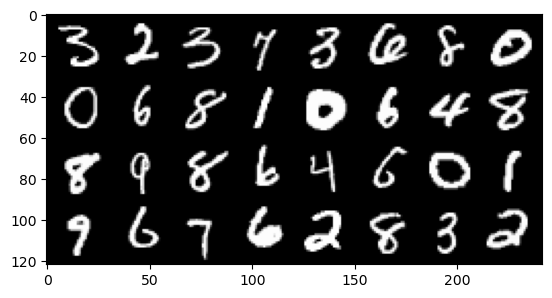

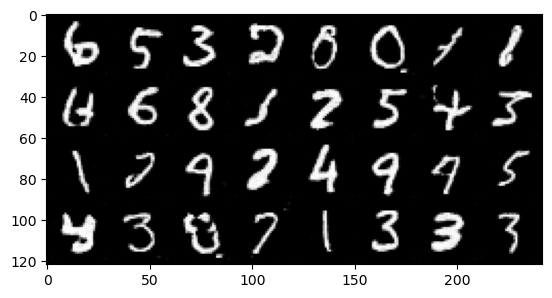

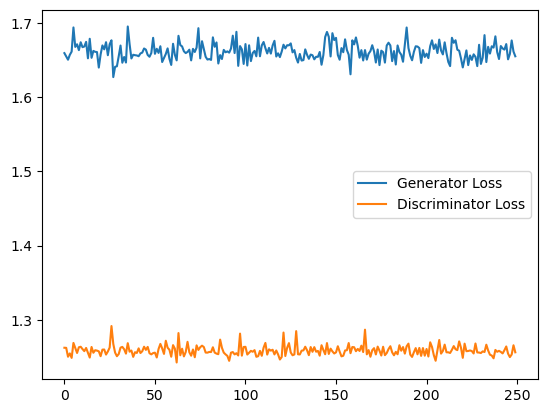

 32%|███▏      | 150/469 [00:05<00:12, 26.24it/s]

Epoch 21, step 10000: Generator loss: 1.66, discriminator loss: 1.26


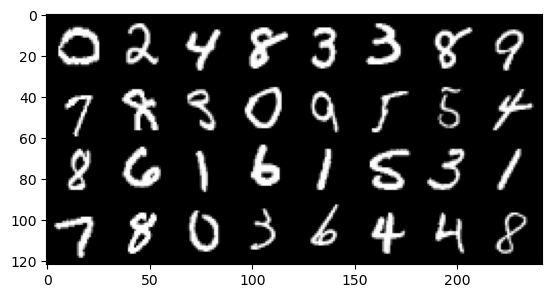

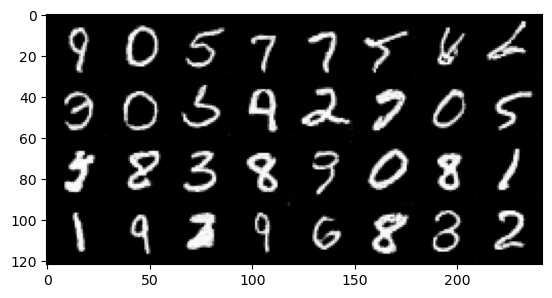

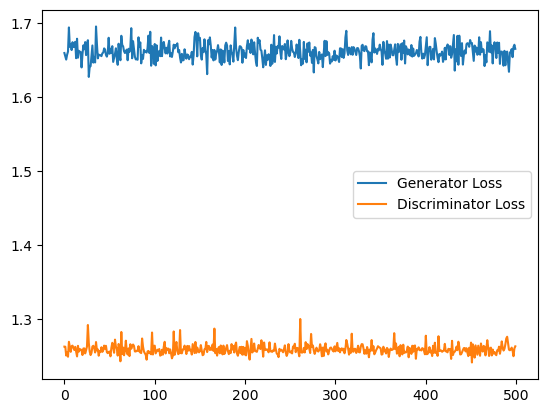

 98%|█████████▊| 459/469 [00:17<00:00, 26.64it/s]

Epoch 31, step 15000: Generator loss: 1.66, discriminator loss: 1.26


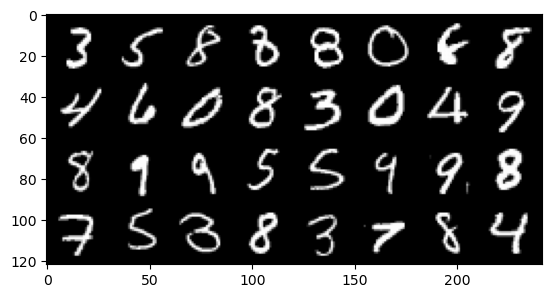

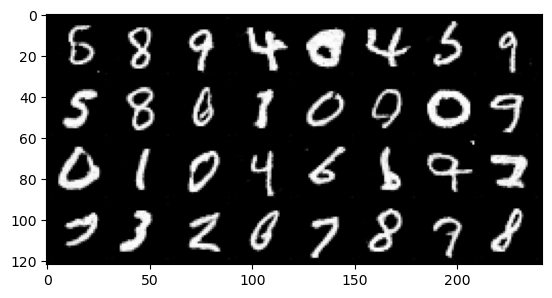

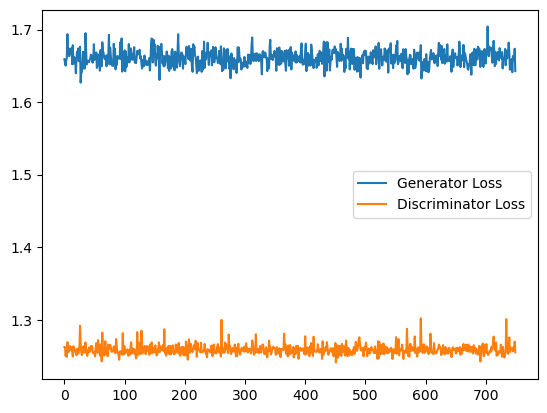

 64%|██████▍   | 300/469 [00:11<00:06, 25.94it/s]

Epoch 42, step 20000: Generator loss: 1.66, discriminator loss: 1.26


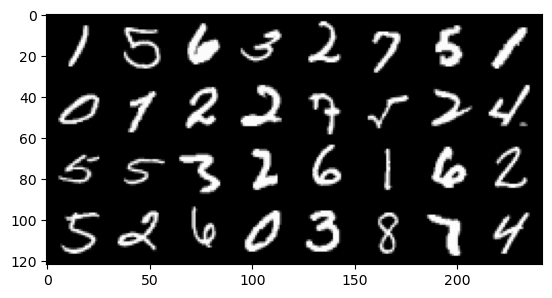

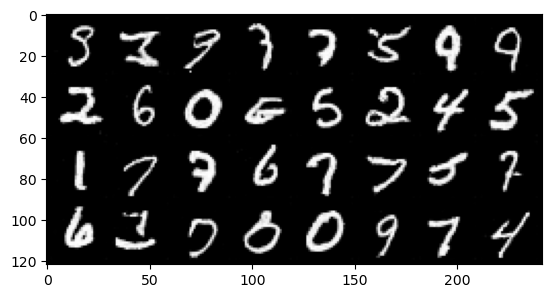

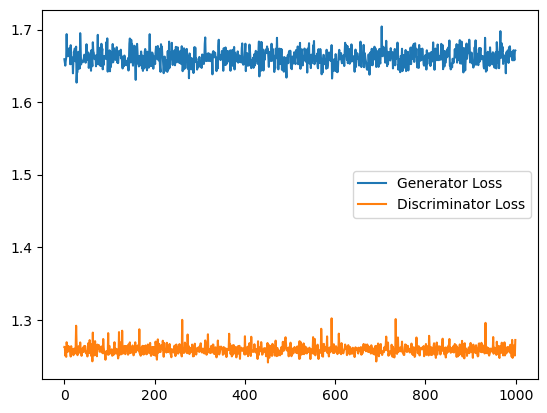

 30%|███       | 141/469 [00:05<00:12, 26.98it/s]

Epoch 53, step 25000: Generator loss: 1.66, discriminator loss: 1.26


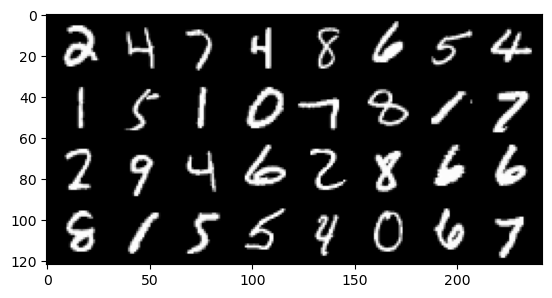

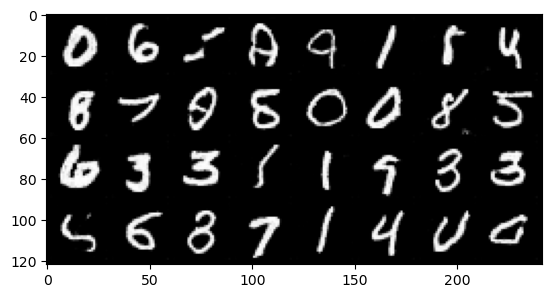

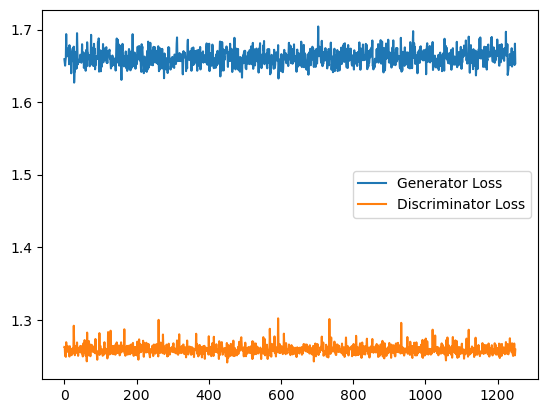

 97%|█████████▋| 453/469 [00:17<00:00, 25.63it/s]

Epoch 63, step 30000: Generator loss: 1.67, discriminator loss: 1.26


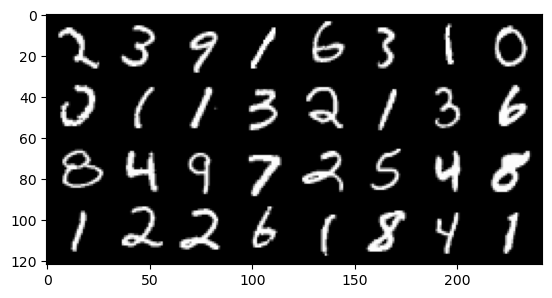

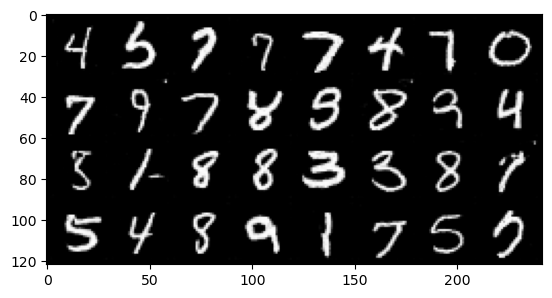

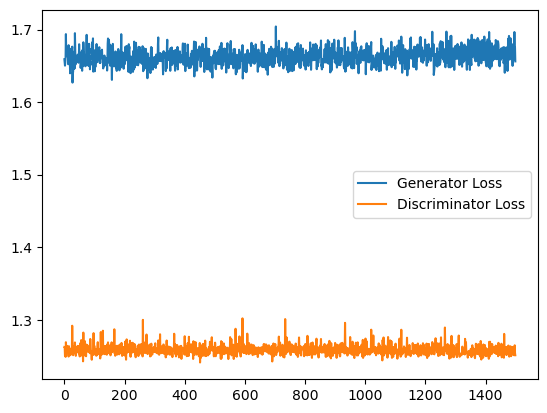

 63%|██████▎   | 294/469 [00:11<00:06, 26.65it/s]

Epoch 74, step 35000: Generator loss: 1.67, discriminator loss: 1.26


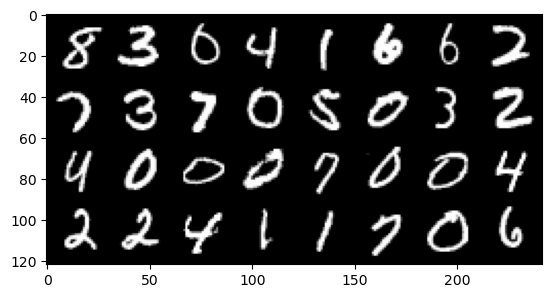

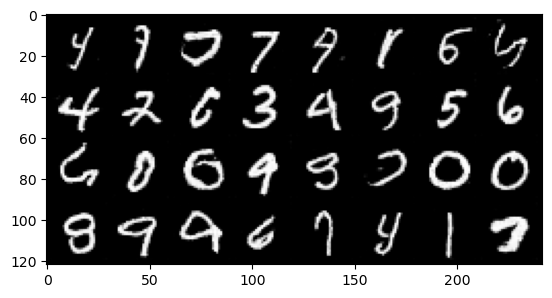

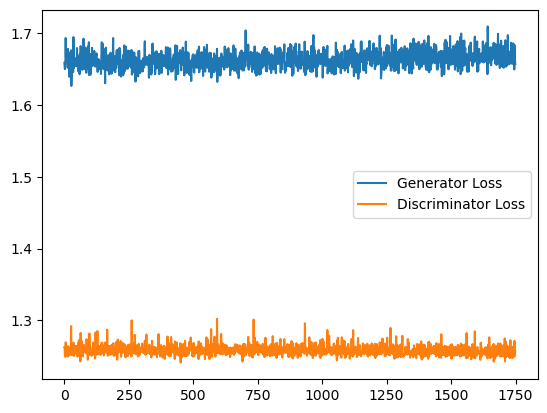

 29%|██▉       | 135/469 [00:05<00:13, 24.81it/s]

Epoch 85, step 40000: Generator loss: 1.67, discriminator loss: 1.26


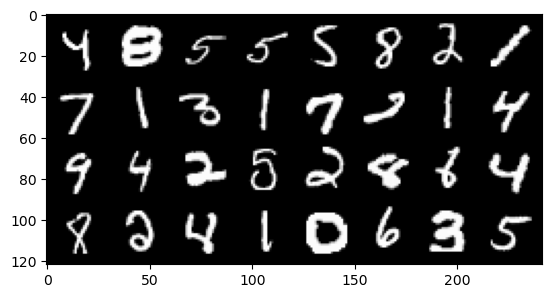

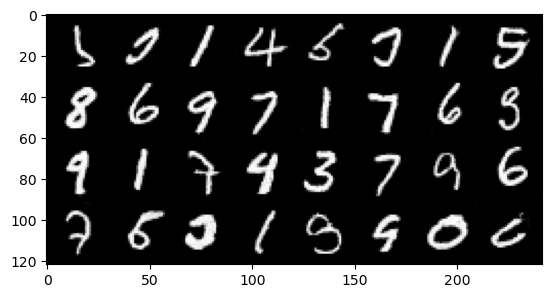

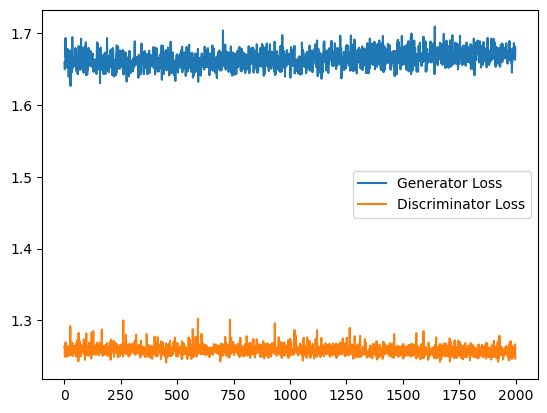

 94%|█████████▍| 443/469 [00:19<00:01, 21.51it/s]

Epoch 95, step 45000: Generator loss: 1.67, discriminator loss: 1.25


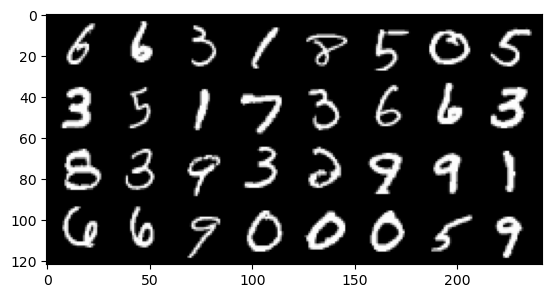

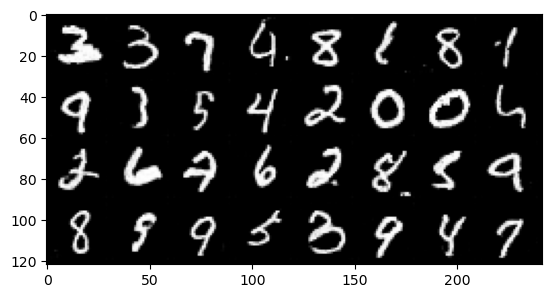

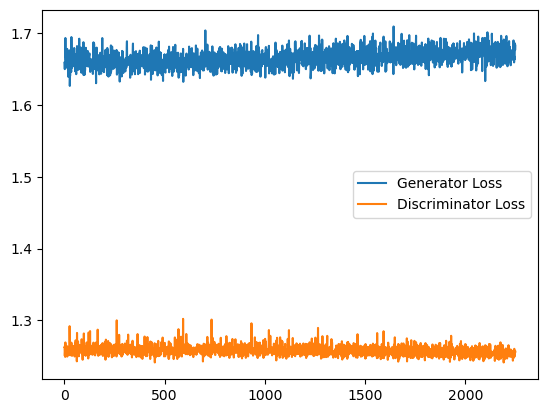

100%|██████████| 469/469 [00:18<00:00, 25.94it/s]


In [15]:
n_epochs = 100
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):

    for real, labels in tqdm(mnist_dl):
        cur_batch_size = len(real)
        real = real.to(device)
        labels = labels.to(device)
        
        
        ## Update discriminator ##
        disc_opt.zero_grad()
        
        # Get noise corresponding to the current batch_size
        noise = get_noise(cur_batch_size, z_dim, device=device)
        fake  = gen(noise)
        gen_fake, aux_fake = disc(fake.detach())
        disc_fake_adv_loss = adv_loss(gen_fake, torch.zeros_like(gen_fake, device=device))
        disc_fake_aux_loss = aux_loss(aux_fake, labels)
        disc_fake_loss = (disc_fake_adv_loss+disc_fake_aux_loss)/2

        gen_real, aux_real = disc(real)
        disc_real_adv_loss = adv_loss(gen_real, torch.ones_like(gen_real, device=device))
        disc_real_aux_loss = aux_loss(aux_real, labels)
        disc_real_loss = (disc_real_adv_loss+disc_real_aux_loss)/2

        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]
        
        ### Update generator ###
        gen_opt.zero_grad()
        noise = get_noise(cur_batch_size, z_dim, device=device)
        fake  = gen(noise)
        gen_fake, aux_fake = disc(fake)
        gen_fake_adv_loss = adv_loss(gen_fake, torch.ones_like(gen_fake, device=device))
        gen_fake_aux_loss = aux_loss(aux_fake, labels)
        gen_fake_loss = (gen_fake_adv_loss+gen_fake_aux_loss)/2
        gen_fake_loss.backward()
        gen_opt.step()
        
        # Keep track of the average generator loss
        generator_losses += [gen_fake_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            mean_gen_loss = sum(generator_losses[-display_step:]) / display_step
            mean_disc_loss = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_gen_loss:.2f}, discriminator loss: {mean_disc_loss:.2f}")
            generator_loss = 0
            discriminator_loss = 0
            show_img_batch((real + 1) / 2)
            show_img_batch((fake + 1) / 2)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(range(num_examples // step_bins), 
                     torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                     label="Generator Loss")
            plt.plot(range(num_examples // step_bins), 
                     torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                     label="Discriminator Loss"
                     )
            plt.legend()
            plt.show()
        cur_step += 1


In [16]:
torch.save({
    'generator': gen.state_dict(), 
    'discriminator': disc.state_dict(), 
    'gen_opt': gen_opt.state_dict(), 
    'disc_opt': disc_opt.state_dict()
    }, 
    'acgan_models.pth')

In [ ]:
models = torch.load('cgan_models.pth')
gen_loaded = Generator(z_dim=z_dim+n_classes).to(device)
disc_loaded = Discriminator(im_chan=1+n_classes).to(device)
gen_loaded.load_state_dict(models['generator'])
disc_loaded.load_state_dict(models['discriminator']) 

In [ ]:
noise = get_noise(32, z_dim, device)
labels_ = torch.randint(0, 10, (32, ), device=device)
one_hot_vec = tf.one_hot(labels_, num_classes=10)
gen_input = combine_tensors(noise, one_hot_vec)
show_img_batch(gen_loaded(gen_input))